In [70]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import keras_tuner 
from keras_tuner import RandomSearch

In [33]:
train_images, train_labels = pd.read_csv('./Data/Image Classification CNN Keras Dataset/input.csv'), pd.read_csv('./Data/Image Classification CNN Keras Dataset/labels.csv')
test_images, test_labels = pd.read_csv('./Data/Image Classification CNN Keras Dataset/input_test.csv'), pd.read_csv('./Data/Image Classification CNN Keras Dataset/labels_test.csv')

In [36]:
train_images = train_images.values.reshape(len(train_images), 100, 100, 3)
test_images = test_images.values.reshape(len(test_images), 100, 100, 3)

In [38]:
train_labels = train_labels.values.reshape(len(train_labels), 1)
test_labels = test_labels.values.reshape(len(test_labels), 1)

In [39]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(1999, 100, 100, 3)
(1999, 1)
(399, 100, 100, 3)
(399, 1)


In [43]:
train_images = train_images/255.
test_images = test_images/255.

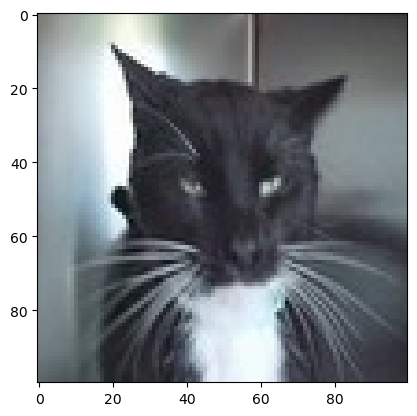

In [69]:
img = np.random.randint(0, len(train_images))
plt.imshow(train_images[img, :])

In [73]:
def build_model(hp):
    model = Sequential([
        Conv2D(
            filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
            kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
            input_shape=(100, 100, 3),
            activation='relu'
        ),
        MaxPool2D(),
        
        Conv2D(
            filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
            kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
            input_shape=(100, 100, 3),
            activation='relu'
        ),
        MaxPool2D(),
        
        Flatten(),
        Dense(
            units=hp.Int('dense_1_units', min_value=32, max_value=64, step=16),
            activation='relu'            
        ),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [74]:
tuner = RandomSearch(
    hypermodel=build_model, 
    objective='val_accuracy',
    executions_per_trial=3,
    max_trials=5,
    directory='output',
    project_name='Image classification with Random Search'
)

In [75]:
tuner.search(train_images, train_labels, validation_data=(test_images, test_labels), epochs=5)

Trial 5 Complete [00h 05m 34s]
val_accuracy: 0.5998329122861227

Best val_accuracy So Far: 0.6599832971890768
Total elapsed time: 00h 40m 27s
INFO:tensorflow:Oracle triggered exit


In [79]:
best_model = tuner.get_best_models()[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 96)        2688      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 32)        27680     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 16928)             0         
                                                                 
 dense (Dense)               (None, 48)                8

In [80]:
best_model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels), verbose=10)

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


<AxesSubplot:>

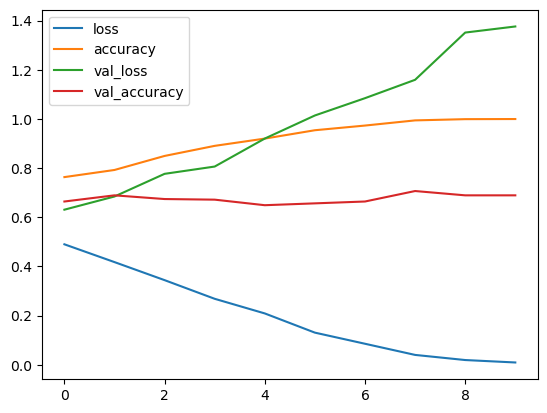

In [82]:
losses = DataFrame(best_model.history.history)
losses.plot()

In [83]:
preds = best_model.evaluate(test_images, test_labels)

13/13 [==============================] - 1s 101ms/step - loss: 1.3759 - accuracy: 0.6892


1/1 [==============================] - 0s 24ms/step
Dog


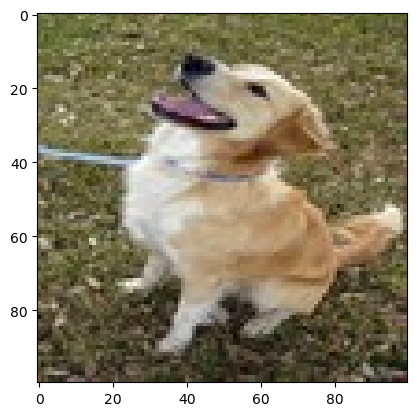

In [125]:
test_img = np.random.randint(0, len(test_images))

test_case = best_model.predict(test_images[test_img, :].reshape(1, 100, 100, 3)) > 0.5
test_case

if test_case[0]:
    print('Cat')
else:
    print('Dog')
    
plt.imshow(test_images[test_img, :])
plt.show()